<a href="https://colab.research.google.com/github/harshnandwana/Machine-learning-projects/blob/main/hand_gesture_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import MulticlassAccuracy
from torchinfo import summary
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import StepLR

device= "cuda" if torch.cuda.is_available() else 'cpu'
print("Torch Version => {} \nIs Torch using CUDA => {} \nTotal GPU available => {} \nCurrently using => {}".format(torch.__version__,torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(torch.cuda.current_device())))

Torch Version => 1.13.0+cu116 
Is Torch using CUDA => True 
Total GPU available => 1 
Currently using => Tesla T4


In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00405/Postures.zip
!unzip Postures.zip

--2022-12-29 06:09:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/00405/Postures.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14660674 (14M) [application/x-httpd-php]
Saving to: ‘Postures.zip’

Postures.zip        100%[===================>]  13.98M  7.59MB/s    in 1.8s    

2022-12-29 06:09:52 (7.59 MB/s) - ‘Postures.zip’ saved [14660674/14660674]

Archive:  Postures.zip
  inflating: Postures.csv            


In [5]:
df=pd.read_csv("Postures.csv")
df.head(2)

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.26388,71.466776,-64.807709,76.895635,42.4625,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Class,78096.0,2.983738,1.421183,0.000000,2.000000,3.000000,4.000000,5.000000
User,78096.0,7.959127,4.697810,0.000000,5.000000,9.000000,12.000000,14.000000
X0,78096.0,50.345664,32.696173,-108.552738,29.295062,54.619964,72.488686,190.017835
Y0,78096.0,85.812051,40.204363,-98.233756,63.494432,86.526246,113.107355,169.175464
Z0,78096.0,-29.984712,34.361918,-126.770872,-56.356438,-30.864125,-1.418803,113.345119
X1,78096.0,49.595209,32.478238,-111.685241,28.755137,54.215514,71.762039,188.691997
Y1,78096.0,86.192647,40.453214,-96.142589,64.154529,87.542751,116.219398,170.209350
Z1,78096.0,-29.509202,34.764398,-166.006838,-57.360107,-30.184005,-0.366692,104.697852
X2,78096.0,48.612121,33.605390,-106.886524,25.170006,53.814580,71.561951,188.760168
Y2,78096.0,83.771315,41.023543,-100.789312,58.052385,86.458324,106.660827,168.186466


In [7]:
df.Class.unique()

array([0, 1, 2, 3, 4, 5])

In [8]:
df.Class[df.Class==0].count()

1

In [9]:
df.drop(df[df.Class==0].index , inplace=True)

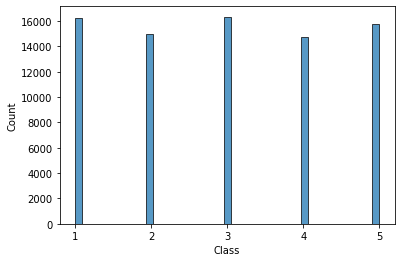

In [10]:
sns.histplot(df.Class)
plt.xticks(range(1,6))
plt.show()

In [11]:
def change(data):
    return data-1
df.Class=df.Class.apply(change)
df.Class.unique()

array([0, 1, 2, 3, 4])

In [12]:
for i in df.columns:
    df[i].replace({"?":float(0)}, inplace=True)

In [13]:
data=df[['Class', 'User', 'X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']]

In [14]:
data.iloc[0:2]

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2
1,0,0,54.263880,71.466776,-64.807709,76.895635,42.46250,-72.780545,36.621229,81.680557,-52.919272
2,0,0,56.527558,72.266609,-61.935252,39.135978,82.53853,-49.596509,79.223743,43.254091,-69.982489


In [15]:
def pltHand(handPoints):
    ls=[]
    crntClass = handPoints['Class'].values[0]
    title="NA"
    for i in range(int((handPoints.shape[1]-2)/3)):
        pntx = f'X{i}'
        pnty = f'Y{i}'
        pntz = f'Z{i}'
        if(handPoints[pntx].values[0] != 0 and handPoints[pnty].values[0] != 0 and handPoints[pntz].values[0] != 0):
            xlocation = handPoints[pntx]
            ylocation = handPoints[pnty]
            zlocation = handPoints[pntz]
            ls.append([xlocation, ylocation, zlocation])
        else:
            continue
    
    if (crntClass == 1):
        title = 'Fist(with thumb out)'
    elif(crntClass == 2):
        title = 'Stop(hand flat)'
    elif (crntClass == 3):
        title = 'Point1(point with pointer finger)'
    elif (crntClass == 4):
        title = 'Point2(point with pointer and middle fingers)'
    elif (crntClass == 5):
        title = 'Grab(fingers curled as if to grab).'
    return title, ls
    
w = np.random.randint(df.shape[0], size=1)[0]
title, ls=pltHand(df[w:w+1] )

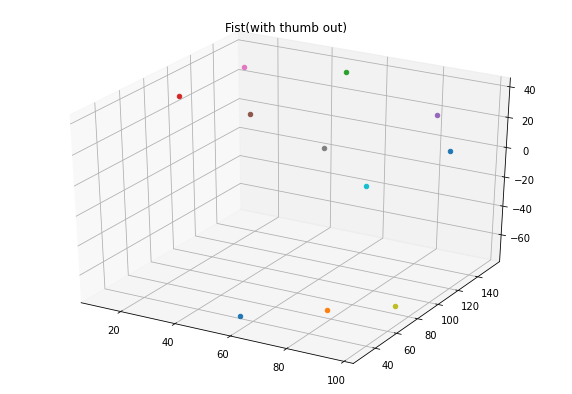

In [16]:
def draw_3d(ls,title):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    for i in ls:
        x=(float(i[0].astype(float)))
        y=(float(i[1].astype(float)))
        z=(float(i[2].astype(float)))
        ax.scatter(x, y, z, marker="o")
    plt.title(title)
    plt.show()
draw_3d(ls,title)

In [17]:
def plot_3d(ls,title):
    x,y,z=[],[],[]
    for i in ls:

        x.append(float(i[0].astype(float)))
        y.append(float(i[1].astype(float)))
        z.append(float(i[2].astype(float)))

    fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                       mode='markers',    
                                       marker=dict(size=4,color=z, colorscale='Viridis',opacity=0.8))])
    fig.update_layout(title_text=title)
    fig.show()
plot_3d(ls,title)

## Load Data in Tensor from DataFrame

In [18]:
x_tr, x_te, y_tr, y_te= train_test_split(data.drop("Class", axis=1), data.Class, test_size=0.25,stratify=data.Class, random_state=15)
len(x_tr), len(x_te), len(y_tr), len(y_te), len(x_tr.columns), len(y_tr.unique())

(58571, 19524, 58571, 19524, 10, 5)

In [19]:
train_target = torch.tensor(y_tr.values)
train = torch.tensor(x_tr.values)
train_tensor = data_utils.TensorDataset(train, train_target)
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 32, shuffle = True)

test_target = torch.tensor(y_te.values)
test = torch.tensor(x_te.values)
test_tensor = data_utils.TensorDataset(test, test_target)
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = 32, shuffle = True)
len(train_loader), len(test_loader)

(1831, 611)

In [20]:
x_tr, y_tr, x_te, y_te=x_tr.to_numpy(),y_tr.to_numpy(), x_te.to_numpy(), y_te.to_numpy()

x_tr=torch.from_numpy(x_tr).type(torch.float).to(device)
x_te=torch.from_numpy(x_te).type(torch.float).to(device)
y_tr=torch.from_numpy(y_tr).type(torch.LongTensor).to(device)
y_te=torch.from_numpy(y_te).type(torch.LongTensor).to(device)

## Model creation

In [21]:
class model(nn.Module):
    def __init__(self, in_feature:int, out_feature:int, hidden_layers:int):
        super().__init__()
        self.layer=nn.Sequential(
            nn.Linear(in_features=in_feature, out_features=hidden_layers),
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers*10),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=hidden_layers*10, out_features=hidden_layers*5),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=hidden_layers*5, out_features=hidden_layers),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layers, out_features=out_feature),
        )
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer(x)
Model=model(in_feature=10, out_feature=5, hidden_layers=64).to(device)

In [22]:
Model.eval()
y_pred=Model(x_tr)
print(f'{y_pred[:2]},\n\n {Model.parameters}')
print(summary(Model))

tensor([[ 0.8631,  3.2384, -0.4117, -0.5684,  0.4536],
        [ 0.8790,  2.4272,  0.4842, -0.6306,  0.7244]], device='cuda:0',
       grad_fn=<SliceBackward0>),

 <bound method Module.parameters of model(
  (layer): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=640, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=640, out_features=320, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=320, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=5, bias=True)
  )
)>
Layer (type:depth-idx)                   Param #
model                                    --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       704
│    └─Linear: 2-2                       41,600
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-

In [23]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device,
               scheduler=False):
    
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.type(torch.float).to(device), y.type(torch.LongTensor).to(device) # Send data to GPU
#         X, y = X.to(device), y.to(device)
#         print(type(X), type(y), X.dtype, y.dtype, X.shape)
        y_pred = model(X) # 1. Forward pass
        loss = loss_fn(y_pred, y) # 2. Calculate loss
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1),y) # Go from logits -> pred label        
        optimizer.zero_grad() # 3. Optimizer zero grad
        loss.backward() # 4. Loss backwardrr
        if scheduler !=False:
            scheduler.step() # 5. Optimizer step
        else:
            optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.type(torch.float).to(device), y.type(torch.LongTensor).to(device)
            test_pred = model(X)# 1. Forward pass
            
            test_loss += loss_fn(test_pred, y) # 2. Calculate loss and accuracy
            test_acc += accuracy_fn(test_pred.argmax(dim=1),y)# Go from logits -> pred labels
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")



In [24]:
acc=MulticlassAccuracy(num_classes=5).to(device)

optim=torch.optim.Adam(params=Model.parameters(), lr=0.001)
# Scheduler = StepLR(optim, step_size=5, gamma=0.1)

loss_fn=nn.CrossEntropyLoss()
for epoch in (range(15)):
    print(f"\nEpoch: {epoch+1}\n---------")
    try:
        train_step(data_loader=train_loader, model=Model, loss_fn=loss_fn,optimizer=optim,accuracy_fn=MulticlassAccuracy(num_classes=5).to(device), scheduler=False)
    #     if epoch%4==0:
        test_step(data_loader=test_loader,model=Model,loss_fn=loss_fn,accuracy_fn=MulticlassAccuracy(num_classes=5).to(device))
    except Exception as e:
        print(e)



Epoch: 1
---------
Train loss: 0.72123 | Train accuracy: 0.72%
Test loss: 0.52389 | Test accuracy: 0.81%


Epoch: 2
---------
Train loss: 0.43166 | Train accuracy: 0.84%
Test loss: 0.38018 | Test accuracy: 0.86%


Epoch: 3
---------
Train loss: 0.32697 | Train accuracy: 0.88%
Test loss: 0.31251 | Test accuracy: 0.89%


Epoch: 4
---------
Train loss: 0.27013 | Train accuracy: 0.90%
Test loss: 0.25084 | Test accuracy: 0.91%


Epoch: 5
---------
Train loss: 0.23949 | Train accuracy: 0.91%
Test loss: 0.23254 | Test accuracy: 0.92%


Epoch: 6
---------
Train loss: 0.21159 | Train accuracy: 0.92%
Test loss: 0.24665 | Test accuracy: 0.92%


Epoch: 7
---------
Train loss: 0.19399 | Train accuracy: 0.93%
Test loss: 0.23744 | Test accuracy: 0.92%


Epoch: 8
---------
Train loss: 0.17725 | Train accuracy: 0.94%
Test loss: 0.23216 | Test accuracy: 0.92%


Epoch: 9
---------
Train loss: 0.16888 | Train accuracy: 0.94%
Test loss: 0.18899 | Test accuracy: 0.94%


Epoch: 10
---------
Train loss: 0.15

## Evaluation

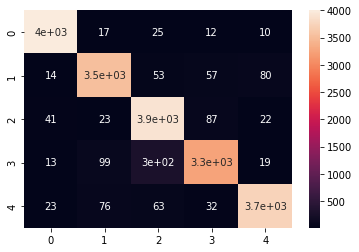

In [25]:
cf=ConfusionMatrix(task="multiclass", num_classes=5).to(device)

Model.eval()
y_pred=Model(x_te)
k=cf(y_pred, y_te).to('cpu')
sns.heatmap(k, annot=True)